#### f1 Scores https://en.wikipedia.org/wiki/F1_score

Train on differnet no of PCs and see how accuracy responds , cut off when it becomes apparant that adding more PCs doesnt buy you more discrimination .

2020-09-07 00:41:29,677 Downloading LFW metadata: https://ndownloader.figshare.com/files/5976012



Faces recognition example using eigenfaces and SVMs

The dataset used in this example is a preprocessed excerpt of the
"Labeled Faces in the Wild", aka LFW_:

  http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz (233MB)

  .. _LFW: http://vis-www.cs.umass.edu/lfw/

  original source: http://scikit-learn.org/stable/auto_examples/applications/face_recognition.html




2020-09-07 00:41:31,045 Downloading LFW metadata: https://ndownloader.figshare.com/files/5976009
2020-09-07 00:41:32,088 Downloading LFW metadata: https://ndownloader.figshare.com/files/5976006
2020-09-07 00:41:33,356 Downloading LFW data (~200MB): https://ndownloader.figshare.com/files/5976015


Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7
Extracting the top 150 eigenfaces from 966 faces
done in 5.029s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.117s
Fitting the classifier to the training set


D:\apps\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


done in 26.876s
Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
Predicting the people names on the testing set
done in 0.056s
                   precision    recall  f1-score   support

     Ariel Sharon       0.56      0.69      0.62        13
     Colin Powell       0.74      0.87      0.80        60
  Donald Rumsfeld       0.76      0.81      0.79        27
    George W Bush       0.93      0.87      0.90       146
Gerhard Schroeder       0.76      0.76      0.76        25
      Hugo Chavez       0.73      0.53      0.62        15
       Tony Blair       0.88      0.83      0.86        36

         accuracy                           0.83       322
        macro avg       0.77      0.77      0.76       322
     weighted avg       0.84      0.83      0.83      

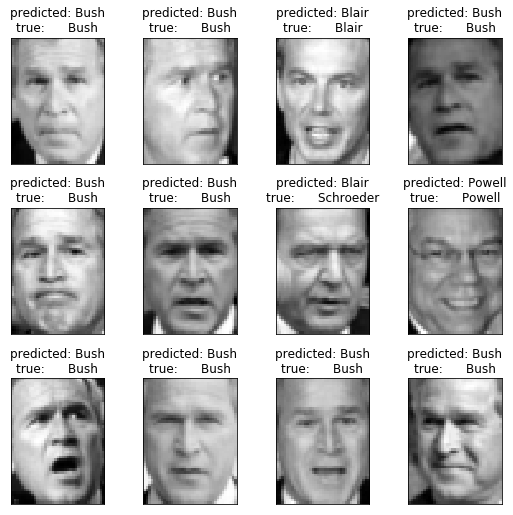

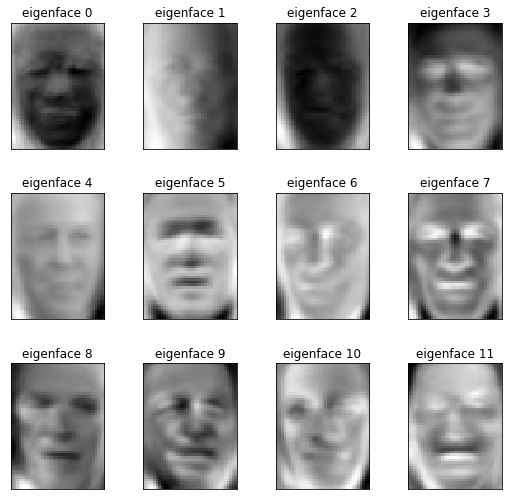

In [12]:
"""
===================================================
Faces recognition example using eigenfaces and SVMs
===================================================

The dataset used in this example is a preprocessed excerpt of the
"Labeled Faces in the Wild", aka LFW_:

  http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz (233MB)

  .. _LFW: http://vis-www.cs.umass.edu/lfw/

  original source: http://scikit-learn.org/stable/auto_examples/applications/face_recognition.html

"""



print (__doc__)

from time import time
import logging
import pylab as pl
import numpy as np

from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import learning_curve, GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA as RandomizedPCA
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')


###############################################################################
# Download the data, if not already on disk and load it as numpy arrays
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape
np.random.seed(42)

# for machine learning we use the data directly (as relative pixel
# position info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print ("Total dataset size:")
print ("n_samples: %d" % n_samples)
print ("n_features: %d" % n_features)
print ("n_classes: %d" % n_classes)


###############################################################################
# Split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

###############################################################################
# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
# dataset): unsupervised feature extraction / dimensionality reduction
n_components = 150

print ("Extracting the top %d eigenfaces from %d faces" % (n_components, X_train.shape[0]))
t0 = time()
pca = RandomizedPCA(n_components=n_components, whiten=True).fit(X_train)
print ("done in %0.3fs" % (time() - t0))

eigenfaces = pca.components_.reshape((n_components, h, w))

print ("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print ("done in %0.3fs" % (time() - t0))


###############################################################################
# Train a SVM classification model

print ("Fitting the classifier to the training set")
t0 = time()
param_grid = {
         'C': [1e3, 5e3, 1e4, 5e4, 1e5],
          'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],
          }
# for sklearn version 0.16 or prior, the class_weight parameter value is 'auto'
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
clf = clf.fit(X_train_pca, y_train)
print ("done in %0.3fs" % (time() - t0))
print ("Best estimator found by grid search:")
print (clf.best_estimator_)


###############################################################################
# Quantitative evaluation of the model quality on the test set

print ("Predicting the people names on the testing set")
t0 = time()
y_pred = clf.predict(X_test_pca)
print ("done in %0.3fs" % (time() - t0))

print (classification_report(y_test, y_pred, target_names=target_names))
print (confusion_matrix(y_test, y_pred, labels=range(n_classes)))


###############################################################################
# Qualitative evaluation of the predictions using matplotlib

def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    pl.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    pl.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        pl.subplot(n_row, n_col, i + 1)
        pl.imshow(images[i].reshape((h, w)), cmap=pl.cm.gray)
        pl.title(titles[i], size=12)
        pl.xticks(())
        pl.yticks(())


# plot the result of the prediction on a portion of the test set

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return ('predicted: %s\ntrue:      %s' % (pred_name, true_name))

prediction_titles = [title(y_pred, y_test, target_names, i)
                         for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)

# plot the gallery of the most significative eigenfaces

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

pl.show()

In [14]:

def compute(n_components):
    print ("Extracting the top %d eigenfaces from %d faces" % (n_components, X_train.shape[0]))
    t0 = time()
    pca = RandomizedPCA(n_components=n_components, whiten=True).fit(X_train)
    print ("done in %0.3fs" % (time() - t0))

    eigenfaces = pca.components_.reshape((n_components, h, w))

    print ("Projecting the input data on the eigenfaces orthonormal basis")
    t0 = time()
    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_test)
    print ("done in %0.3fs" % (time() - t0))


    ###############################################################################
    # Train a SVM classification model

    print ("Fitting the classifier to the training set")
    t0 = time()
    param_grid = {
             'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],
              }
    # for sklearn version 0.16 or prior, the class_weight parameter value is 'auto'
    clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
    clf = clf.fit(X_train_pca, y_train)
    print ("done in %0.3fs" % (time() - t0))
    print ("Best estimator found by grid search:")
    print (clf.best_estimator_)


    ###############################################################################
    # Quantitative evaluation of the model quality on the test set

    print ("Predicting the people names on the testing set")
    t0 = time()
    y_pred = clf.predict(X_test_pca)
    print ("done in %0.3fs" % (time() - t0))

    print (classification_report(y_test, y_pred, target_names=target_names))
    print (confusion_matrix(y_test, y_pred, labels=range(n_classes)))
    
for nc in [10,15,25,50,100,250]:
    print("n_components ",nc)
    compute(nc)


n_components  10
Extracting the top 10 eigenfaces from 966 faces
done in 0.702s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.027s
Fitting the classifier to the training set


D:\apps\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


done in 143.969s
Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
Predicting the people names on the testing set
done in 0.026s
                   precision    recall  f1-score   support

     Ariel Sharon       0.10      0.15      0.12        13
     Colin Powell       0.43      0.53      0.48        60
  Donald Rumsfeld       0.26      0.33      0.30        27
    George W Bush       0.66      0.58      0.62       146
Gerhard Schroeder       0.17      0.20      0.18        25
      Hugo Chavez       0.25      0.13      0.17        15
       Tony Blair       0.50      0.39      0.44        36

         accuracy                           0.46       322
        macro avg       0.34      0.33      0.33       322
     weighted avg       0.49      0.46      0.47       

D:\apps\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


done in 50.021s
Best estimator found by grid search:
SVC(C=50000.0, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.0005, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
Predicting the people names on the testing set
done in 0.016s
                   precision    recall  f1-score   support

     Ariel Sharon       0.25      0.46      0.32        13
     Colin Powell       0.64      0.72      0.68        60
  Donald Rumsfeld       0.46      0.63      0.53        27
    George W Bush       0.84      0.67      0.75       146
Gerhard Schroeder       0.40      0.48      0.44        25
      Hugo Chavez       0.55      0.40      0.46        15
       Tony Blair       0.47      0.47      0.47        36

         accuracy                           0.62       322
        macro avg       0.52      0.55      0.52       322
     weighted avg       0.66      0.62      0.63    

D:\apps\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


done in 29.341s
Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
Predicting the people names on the testing set
done in 0.064s
                   precision    recall  f1-score   support

     Ariel Sharon       0.56      0.69      0.62        13
     Colin Powell       0.72      0.87      0.79        60
  Donald Rumsfeld       0.50      0.56      0.53        27
    George W Bush       0.87      0.82      0.84       146
Gerhard Schroeder       0.56      0.56      0.56        25
      Hugo Chavez       0.89      0.53      0.67        15
       Tony Blair       0.70      0.64      0.67        36

         accuracy                           0.75       322
        macro avg       0.69      0.67      0.67       322
     weighted avg       0.76      0.75      0.75       

D:\apps\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


done in 16.477s
Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
Predicting the people names on the testing set
done in 0.046s
                   precision    recall  f1-score   support

     Ariel Sharon       0.62      0.77      0.69        13
     Colin Powell       0.83      0.92      0.87        60
  Donald Rumsfeld       0.70      0.59      0.64        27
    George W Bush       0.86      0.90      0.88       146
Gerhard Schroeder       0.70      0.64      0.67        25
      Hugo Chavez       0.71      0.67      0.69        15
       Tony Blair       0.82      0.64      0.72        36

         accuracy                           0.81       322
        macro avg       0.75      0.73      0.74       322
     weighted avg       0.81      0.81      0.81       

D:\apps\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


done in 29.535s
Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.005, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
Predicting the people names on the testing set
done in 0.089s
                   precision    recall  f1-score   support

     Ariel Sharon       0.71      0.77      0.74        13
     Colin Powell       0.83      0.90      0.86        60
  Donald Rumsfeld       0.74      0.63      0.68        27
    George W Bush       0.88      0.95      0.91       146
Gerhard Schroeder       0.91      0.80      0.85        25
      Hugo Chavez       0.91      0.67      0.77        15
       Tony Blair       0.90      0.75      0.82        36

         accuracy                           0.86       322
        macro avg       0.84      0.78      0.80       322
     weighted avg       0.86      0.86      0.85      

D:\apps\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


done in 86.131s
Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
Predicting the people names on the testing set
done in 0.204s
                   precision    recall  f1-score   support

     Ariel Sharon       0.65      0.85      0.73        13
     Colin Powell       0.76      0.92      0.83        60
  Donald Rumsfeld       0.88      0.78      0.82        27
    George W Bush       0.93      0.89      0.91       146
Gerhard Schroeder       0.77      0.80      0.78        25
      Hugo Chavez       0.78      0.47      0.58        15
       Tony Blair       0.82      0.78      0.80        36

         accuracy                           0.84       322
        macro avg       0.80      0.78      0.78       322
     weighted avg       0.85      0.84      0.84      